Experiments on interpreting the logistic weights when classifying the MNIST digits.

## Initial setup

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import torch
import data_util
from model_interpretation import viz

# Where to download MNIST
root = 'K:/datasets/classification'
# Number of images to use
n = 5000
# Seed for reproducibility
random.seed(42)

data_train, labels_train, data_valid, labels_valid = data_util.get_mnist_numpy(root, n)

Accuracy: 89.64


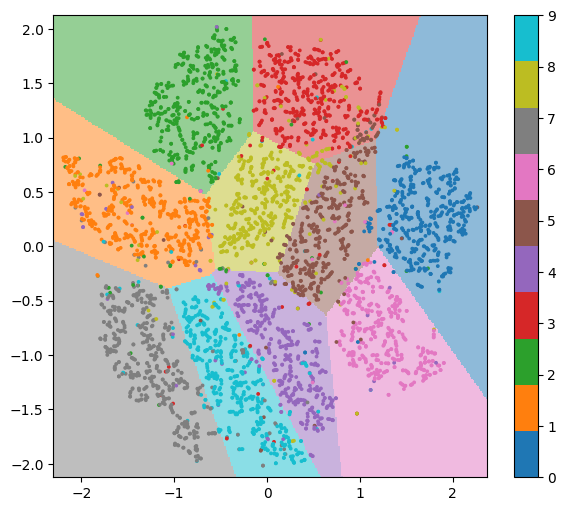

In [2]:
# 2D projection using t-SNE and logistic regression
mapper = TSNE(perplexity=7, learning_rate='auto')
proj_tsne = mapper.fit_transform(data_train)
proj_tsne = data_util.normalize(proj_tsne)
labels_train
logreg = LogisticRegression(C=1000)
logreg.fit(proj_tsne, labels_train)

print('Accuracy:', 100*logreg.score(proj_tsne, labels_train))

viz.plot_regions(logreg.predict, proj_tsne, labels_train)

## Model interpretation

Training the logistic model using L1 regularization leads to smoother and more intuitive attribution maps

In [5]:
#logreg = LogisticRegression(C=0.01, max_iter=100, tol=0.1)
logreg = LogisticRegression(C=0.1, penalty="l1", solver="saga", tol=0.1)
logreg.fit(data_train, labels_train)
print('Train accuracy:', 100*logreg.score(data_train, labels_train))
print('Valid accuracy:', 100*logreg.score(data_valid, labels_valid))

Train accuracy: 92.66
Valid accuracy: 90.29


In [4]:
def create_model(logreg):
    """Create a linear layer using the weights of the logistic regression."""

    model = torch.nn.Linear(28*28, 10)
    model.requires_grad_(False)
    model.weight[:] = torch.tensor(logreg.coef_)
    model.bias[:] = torch.tensor(logreg.intercept_)

    return model

model = create_model(logreg)
data_train_pt = torch.tensor(data_train)
labels_train_pt = torch.tensor(labels_train)

Accuracy: 92.72000193595886


### Logistic weights

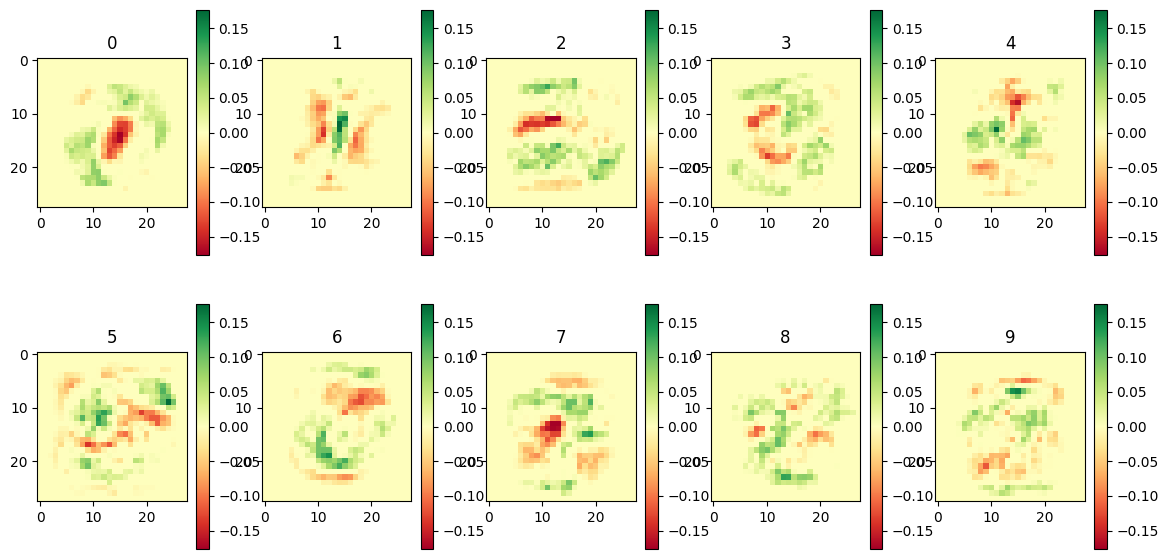

In [9]:
cn = plt.matplotlib.colors.CenteredNorm()
plt.figure(figsize=(14, 7))
for idx in range(10):
    # Reshape the weights as an image
    weight = model.weight[idx].reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)


### Attributions for an image

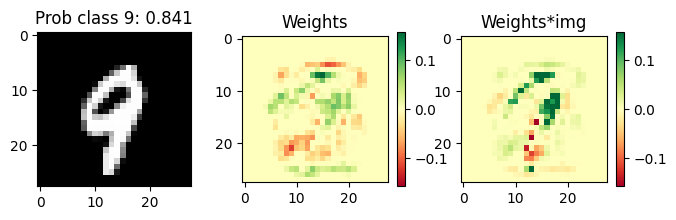

In [10]:
def attribution(model, data, labels, idx):
    cn = plt.matplotlib.colors.CenteredNorm()

    x = data[idx]
    label = labels[idx]
    img = x.reshape(28,28)
    weight = model.weight[label].reshape(28,28)
    prob = model(x[None]).softmax(dim=1)[0][label]

    plt.figure(figsize=(8,2))
    plt.subplot(1, 3, 1)
    plt.imshow(img, 'gray')
    plt.title(f'Prob class {label}: {prob:.3f}')
    plt.subplot(1, 3, 2)
    plt.imshow(weight, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title('Weights')
    plt.subplot(1, 3, 3)
    plt.imshow(weight*img, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title('Weights*img')

idx = 0 # idx of the image
attribution(model, data_train_pt, labels_train_pt, idx)


Below we answer the question: For the given image, which pixels lead the model to classify the image as class c?

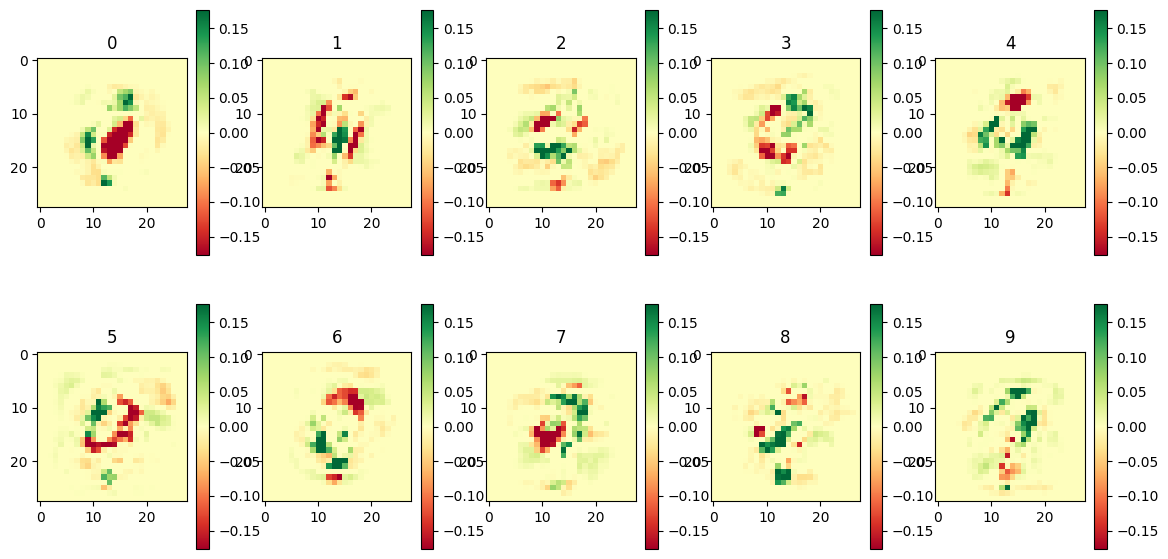

In [11]:
img = data_train_pt[idx].reshape(28,28)

plt.figure(figsize=(14, 7))
for idx in range(10):
    weight = model.weight[idx].reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight*img, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)

### 2-class attributions

We can also study which pixels lead the model to classify an image into class c instead of class ci

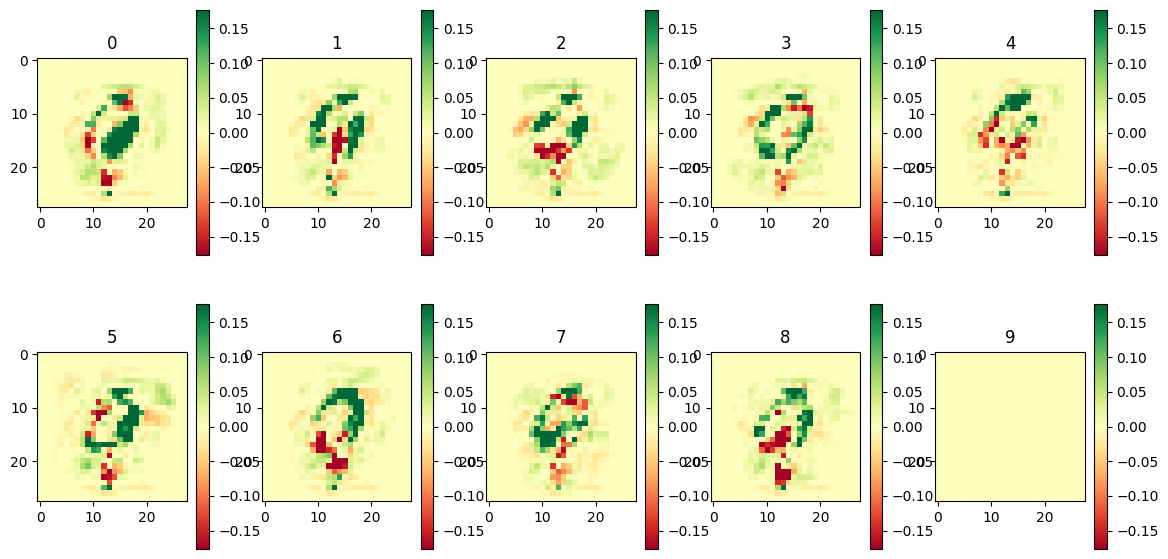

In [12]:
label = 9
plt.figure(figsize=(14, 7))
for idx in range(10):
    weight = model.weight[label] - model.weight[idx] 
    weight = weight.reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight*img, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)

### 2-class attributions considering class prototypes

We have studied the classification of a specific image. This image might be different from the "typical" image of its class. Thus, we can also do the same analysis using class prototypes.

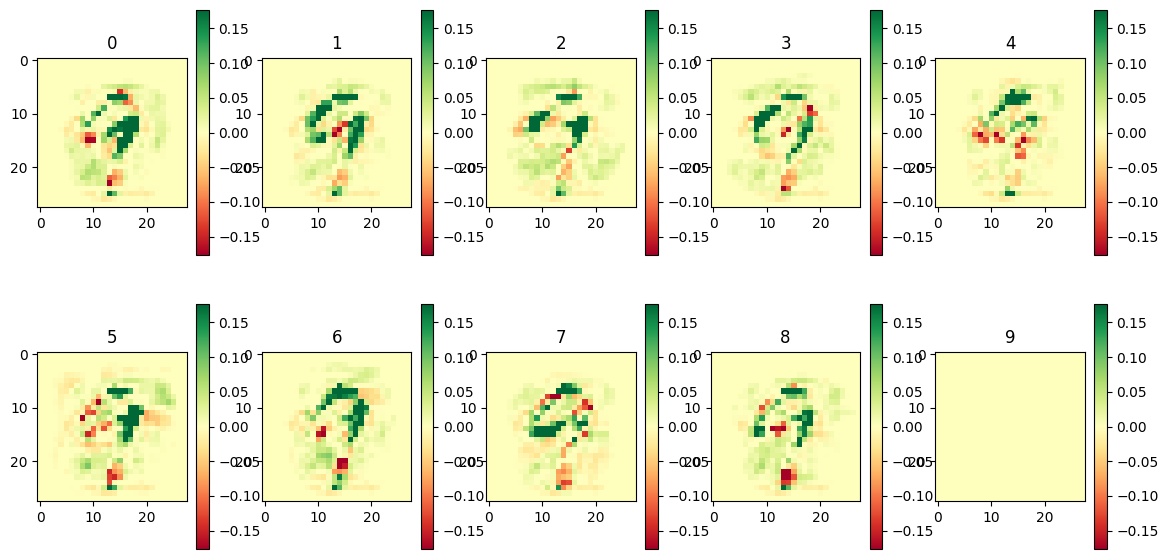

In [13]:
from scipy.spatial import KDTree

def prototypes(data, labels):
    """Find samples at the center of each class (warning, average might not be at the peak of the distribution)"""
    tree = KDTree(data)
    imgs = []
  
    for idx in range(10):
        mean = data_train[np.array(labels)==idx].mean(axis=0)
        # Find the sample that is the closest to the average of the class.
        d, sample_idx = tree.query(mean)
        imgs.append(data_train[sample_idx].reshape(28,28))

    return imgs

imgs = prototypes(data_train, labels_train)
label = 9

plt.figure(figsize=(14, 7))
for idx in range(10):
    weight = model.weight[label] - model.weight[idx]
    weight = weight.reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight*imgs[9], 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)